Read a image from file, and then write the image to a jpg file.

In [1]:
from scipy.misc import imread, imsave
img = imread('/path/to/image')
imsave('scipyImageWrite.jpg', img) 

from skimage.io import imread, imsave
img = imread('/path/to/image')
imsave('skimageWrite.jpg', img)

Doing FFT using GPU

In [5]:
import matplotlib.pyplot as plt
import numpy
import theano

def gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma]) 
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = numpy.ogrid[-m:m+1,-n:n+1]
    h = numpy.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[h < numpy.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def theanoConv(inputImg, imgFilter):
    '''compute convolutions using FFT, GPU with Theano
    inputImg: input image, numpy array
    imgFilter: image filter, numpy array,
    mode: theano.compile.mode object, specify to use FFT to compute convolutions'''
    from theano import function
    import theano.tensor as T
    from theano.tensor.nnet import conv
    import theano.sandbox.cuda
    # build symbolic computation functions for theano
    symimg = T.ftensor4()
    symfilter = T.ftensor4()
    image_shape = inputImg.shape
    filter_shape = imgFilter.shape
    sym_convout = conv.conv2d(
                input=symimg,
                filters=symfilter,
                filter_shape=filter_shape,
                image_shape=image_shape, 
                border_mode = 'full'
            )
    f = function([symimg, symfilter], sym_convout)
    print f.maker.fgraph.toposort()


    convout = f(inputImg, imgFilter) 

    if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
        print 'Used the cpu'
    else:
        print 'Used the gpu'
    return convout

m, n = img.shape # image shape
fsize = 5 # filter size

inputImg = numpy.empty((1, 1, m, n), dtype = numpy.float32) # build input image cb01 format
inputImg[0, 0, :, :] = img
imgFilter= numpy.empty((1, 1, fsize, fsize), dtype = numpy.float32) # build filter in cb01 format
imgFilter[0, 0, :, :] = gauss2D(shape = (fsize, fsize), sigma = 0.5)

convout = theanoConv(inputImg, imgFilter) # perform convolution

plt.imshow(convout[0, 0, :, :], cmap = 'gray') # show results
plt.show()

[ConvOp{('imshp', (1, 480, 640)),('kshp', (5, 5)),('nkern', 1),('bsize', 1),('dx', 1),('dy', 1),('out_mode', 'full'),('unroll_batch', None),('unroll_kern', None),('unroll_patch', True),('imshp_logical', (1, 480, 640)),('kshp_logical', (5, 5)),('kshp_logical_top_aligned', True)}(<TensorType(float32, 4D)>, <TensorType(float32, 4D)>)]
Used the gpu


NOT Transfering data to CPU by adding theano.sandbox.cuda.basic_ops.gpu_from_host

In [7]:
import matplotlib.pyplot as plt
import numpy

mode = theano.compile.get_default_mode()
mode = mode.including('conv_fft')

def gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = numpy.ogrid[-m:m+1,-n:n+1]
    h = numpy.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < numpy.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def theanoConv(inputImg, imgFilter, mode):
    '''compute convolutions using FFT, GPU with Theano
    inputImg: input image, numpy array
    imgFilter: image filter, numpy array,
    mode: theano.compile.mode object, specify to use FFT to compute convolutions'''
    from theano import function
    import theano.tensor as T
    from theano.tensor.nnet import conv
    import theano.sandbox.cuda
    import theano.sandbox.cuda.basic_ops
    # build symbolic computation functions for theano
    symimg = T.ftensor4()
    symfilter = T.ftensor4()
    image_shape = inputImg.shape
    filter_shape = imgFilter.shape
    sym_convout = conv.conv2d(
                input=symimg,
                filters=symfilter,
                filter_shape=filter_shape,
                image_shape=image_shape, 
                border_mode = 'full'
            )
    f = function([symimg, symfilter], theano.sandbox.cuda.basic_ops.gpu_from_host(sym_convout))
    print f.maker.fgraph.toposort()


    convout = f(inputImg, imgFilter)

    if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
        print 'Used the cpu'
    else:
        print 'Used the gpu'
    return convout

m, n = img.shape # image shape
fsize = 5 # filter size

inputImg = numpy.empty((1, 1, m, n), dtype = numpy.float32) # build input image cb01 format
inputImg[0, 0, :, :] = img
imgFilter= numpy.empty((1, 1, fsize, fsize), dtype = numpy.float32) # build filter in cb01 format
imgFilter[0, 0, :, :] = gauss2D(shape = (fsize, fsize), sigma = 0.5)

convout = theanoConv(inputImg, imgFilter, mode) # perform convolution

[GpuFromHost(<TensorType(float32, 4D)>), GpuFromHost(<TensorType(float32, 4D)>), GpuContiguous(GpuFromHost.0), GpuDimShuffle{1,0,2,3}(GpuFromHost.0), GpuContiguous(GpuDimShuffle{1,0,2,3}.0), GpuCorrMM_gradInputs{valid, (1, 1)}(GpuContiguous.0, GpuContiguous.0)]
Used the gpu


Rotate, scale and connected components analysis

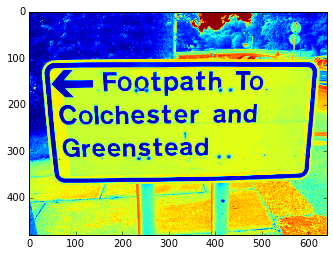

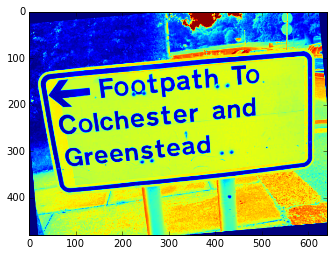

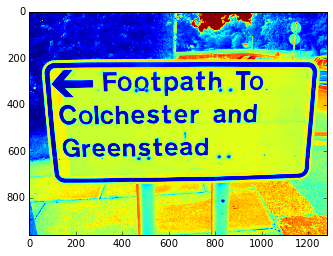

In [16]:
%matplotlib inline
plt.imshow(img)
plt.show()

from skimage.transform import rotate, rescale

rimg = rotate(img, 5)
simg = rescale(img, 2)

plt.imshow(rimg)
plt.show()

plt.imshow(simg)
plt.show()

In [3]:
from joblib import Parallel, delayed

def testfunc(para): 
    '''This is the function run in the child process for a multiprocess'''
    gpuname = 'gpu'+str(int(para)) # set the gpu name
    print gpuname
    theano.sandbox.cuda.use(gpuname) '''specify device name for each process, so you can use multiple GPUs'''
    return 
output = Parallel(n_jobs = 2)(delayed(testfunc)(para) for para in range(2))

In [5]:
theano.sandbox.cuda.use('gpu1')

WARNING (theano.sandbox.cuda): Ignoring call to use(1), GPU number 0 is already in use.
